# Imports and System Setup

In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Dataset, DataLoader as GNNLoader, Data
import cv2
import numpy as np
from pathlib import Path

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global Constants
DATA_PATH = "/kaggle/input/cattle-dataset-pig-sheep-cow-horse/CV-PROJECT-4-C.v3i.yolov8"
IMG_SIZE = 224
PATCH_SIZE = 32
NUM_CLASSES = 5
BATCH_SIZE = 32
EPOCHS = 25

Using device: cuda


# Graph Data Loader

In [3]:
class LivestockGraphDataset(Dataset):
    def __init__(self, data_dir, split='train'):
        super().__init__()
        self.img_dir = Path(data_dir) / split / 'images'
        self.label_dir = Path(data_dir) / split / 'labels'
        self.image_files = sorted(list(self.img_dir.glob('*.jpg')) + list(self.img_dir.glob('*.png')))
        print(f"{split.upper()} set: {len(self.image_files)} graphs")

    def len(self): return len(self.image_files)

    def image_to_graph(self, img, label):
        # Extract patches as node features
        patches = img.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
        x = patches.contiguous().view(-1, PATCH_SIZE * PATCH_SIZE)
        
        # Build edges (connecting 4-neighbors in a grid)
        edge_index = []
        grid_size = IMG_SIZE // PATCH_SIZE
        for i in range(grid_size):
            for j in range(grid_size):
                curr = i * grid_size + j
                if i > 0: edge_index.append([curr, (i-1)*grid_size + j])
                if i < grid_size-1: edge_index.append([curr, (i+1)*grid_size + j])
                if j > 0: edge_index.append([curr, i*grid_size + (j-1)])
                if j < grid_size-1: edge_index.append([curr, i*grid_size + (j+1)])
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        return Data(x=x, edge_index=edge_index, y=torch.tensor([label]))

    def get(self, idx):
        img_path = self.image_files[idx]
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_tensor = torch.tensor(img / 255.0, dtype=torch.float)
        
        label = 0
        label_path = self.label_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                line = f.readline().split()
                if line: label = int(line[0])
        return self.image_to_graph(img_tensor, label)

# Instantiate Loaders
train_loader = GNNLoader(LivestockGraphDataset(DATA_PATH, 'train'), batch_size=BATCH_SIZE, shuffle=True)
val_loader = GNNLoader(LivestockGraphDataset(DATA_PATH, 'valid'), batch_size=BATCH_SIZE)
test_loader = GNNLoader(LivestockGraphDataset(DATA_PATH, 'test'), batch_size=BATCH_SIZE)

TRAIN set: 4867 graphs


/tmp/ipykernel_23/124321860.py:45: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = GNNLoader(LivestockGraphDataset(DATA_PATH, 'train'), batch_size=BATCH_SIZE, shuffle=True)


VALID set: 1195 graphs
TEST set: 508 graphs


/tmp/ipykernel_23/124321860.py:46: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = GNNLoader(LivestockGraphDataset(DATA_PATH, 'valid'), batch_size=BATCH_SIZE)
/tmp/ipykernel_23/124321860.py:47: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = GNNLoader(LivestockGraphDataset(DATA_PATH, 'test'), batch_size=BATCH_SIZE)


# GCNN Architecture

In [4]:
class LivestockGCNN(nn.Module):
    def __init__(self, in_channels=1024, hidden_channels=256):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, NUM_CLASSES)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Message Passing
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        
        # Pooling to get a single vector per animal
        x = global_mean_pool(x, batch)
        return self.fc(x)

model = LivestockGCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training

In [5]:
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # --- TRAINING ---
    model.train()
    t_loss, t_correct, t_total = 0, 0, 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        t_loss += loss.item() * data.num_graphs
        t_correct += (out.argmax(dim=1) == data.y).sum().item()
        t_total += data.num_graphs

    # --- VALIDATION ---
    model.eval()
    v_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            v_loss += loss.item() * data.num_graphs
            v_correct += (out.argmax(dim=1) == data.y).sum().item()
            v_total += data.num_graphs

    # Record History
    history['train_loss'].append(t_loss/t_total)
    history['val_loss'].append(v_loss/v_total)
    history['train_acc'].append(100*t_correct/t_total)
    history['val_acc'].append(100*v_correct/v_total)
    
    print(f"Epoch {epoch+1:02d}/{EPOCHS}")
    print(f"  [Train] Loss: {history['train_loss'][-1]:.4f} | Acc: {history['train_acc'][-1]:.2f}%")
    print(f"  [Val]   Loss: {history['val_loss'][-1]:.4f} | Acc: {history['val_acc'][-1]:.2f}%")
    print("-" * 30)

Epoch 01/25
  [Train] Loss: 1.2242 | Acc: 46.81%
  [Val]   Loss: 1.1214 | Acc: 52.13%
------------------------------
Epoch 02/25
  [Train] Loss: 1.0251 | Acc: 58.89%
  [Val]   Loss: 0.9763 | Acc: 58.83%
------------------------------
Epoch 03/25
  [Train] Loss: 0.9630 | Acc: 61.95%
  [Val]   Loss: 1.1040 | Acc: 55.31%
------------------------------
Epoch 04/25
  [Train] Loss: 0.9387 | Acc: 62.69%
  [Val]   Loss: 0.9960 | Acc: 58.33%
------------------------------
Epoch 05/25
  [Train] Loss: 0.8818 | Acc: 65.54%
  [Val]   Loss: 0.8933 | Acc: 60.25%
------------------------------
Epoch 06/25
  [Train] Loss: 0.8617 | Acc: 66.34%
  [Val]   Loss: 0.9937 | Acc: 60.08%
------------------------------
Epoch 07/25
  [Train] Loss: 0.8728 | Acc: 65.65%
  [Val]   Loss: 0.9702 | Acc: 60.00%
------------------------------
Epoch 08/25
  [Train] Loss: 0.7908 | Acc: 70.54%
  [Val]   Loss: 0.7862 | Acc: 68.28%
------------------------------
Epoch 09/25
  [Train] Loss: 0.7653 | Acc: 71.15%
  [Val]   Loss:

# Evaluation

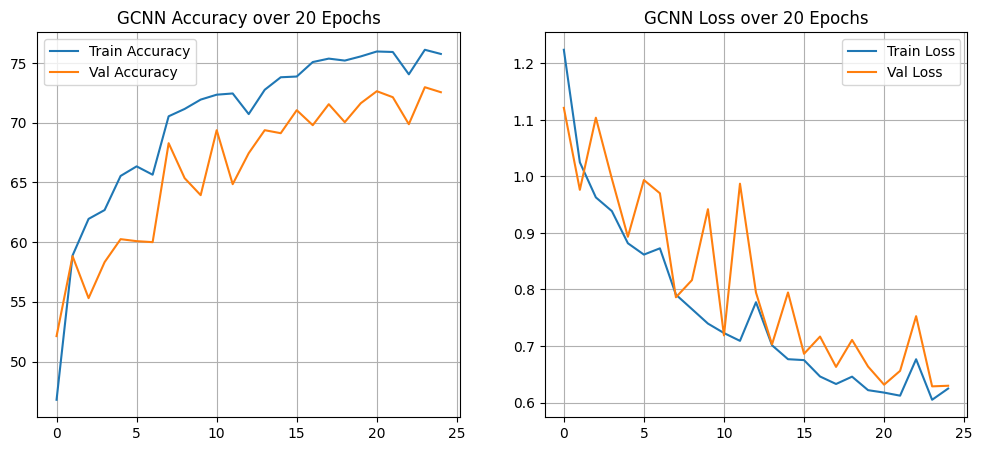

In [6]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('GCNN Accuracy over 20 Epochs'); plt.legend(); plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('GCNN Loss over 20 Epochs'); plt.legend(); plt.grid(True)
plt.show()

# Testing 

In [7]:
# # Final Test Calculation
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        test_correct += (out.argmax(dim=1) == data.y).sum().item()
        test_total += data.num_graphs

print(f"\n>>> FINAL TEST ACCURACY FOR GCNN: {100*test_correct/test_total:.2f}%")


>>> FINAL TEST ACCURACY FOR GCNN: 72.05%
